In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

In [2]:
%matplotlib notebook

# An Introduction to Visualizing Astronomical Images

**Version 0.1**

This session has focused on image processing, with particular attention paid to how we make standard measurements (such as flux or position) in data taken with a wide-field survey, such as the Legacy Survey of Space and Time (LSST) to be conducted by the Vera C. Rubin Observatory. 



Of course, as every good astro-data scientist knows, you should: 

<div align="center">
<br>
<font size="+3"> WORRY ABOUT THE DATA </font>
</div>

When dealing with images, that means *looking at the actual images*. 

This lecture is about the visualization of astronomical images. There are many different aspects that can (should?) be considered within this context. We will focus a primary principle of visualization (recall previous sessions):

  -  Salience - the most important aspects of the figure should stand out

As is often the case when it comes to image processing, Robert Lupton [(Lupton et al. 2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) has written some definitive text on building false color images (we will return to this later). 

* * *

By AA Miller (CIERA/Northwestern & Adler)
2020 July 13

If you haven't already, please [download the images](https://northwestern.box.com/s/bfhgq1jwlz7j69ognvqm5mqpvzm5dbii) that will be necessary for this exercise. Download the entire `data` directory and keep it in the same folder as this notebook. 

Some quick background: these images are taken from the [Zwicky Transient Facilty](https://www.ztf.caltech.edu/).\* ZTF has a 47 $\mathrm{deg}^2$ camera, with $\sim$1 arcsec pixels and $\sim$2 arcsec seeing. It has 3 filters (g, r, i) and has mapped most of the Northern hemisphere. Today we are working with ZTF stacks, roughly 16 individual images has gone into each of these stacks. 

\* Yes, I am biased as a member of ZTF. However, I chose these images because *they aren't all that nice.* SDSS, DES, HSC, PS1, all would have been suitable replacements, typically with better seeing and as a result nicer results. 

## Problem 1) Luminance

We begin by examining how we want to represent the intensity of the light as detected by the ZTF CCD.

**Problem 1a**

Load the data from `data\ztf_i_band.fits.gz` and display a 2D "heatmap" using [`imshow()`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html).

*Note* - CCDs are linear detectors, so use a linear scaling (the default for `imshow()`) of the data in order to "see" what the detector sees.

<IPython.core.display.Javascript object>


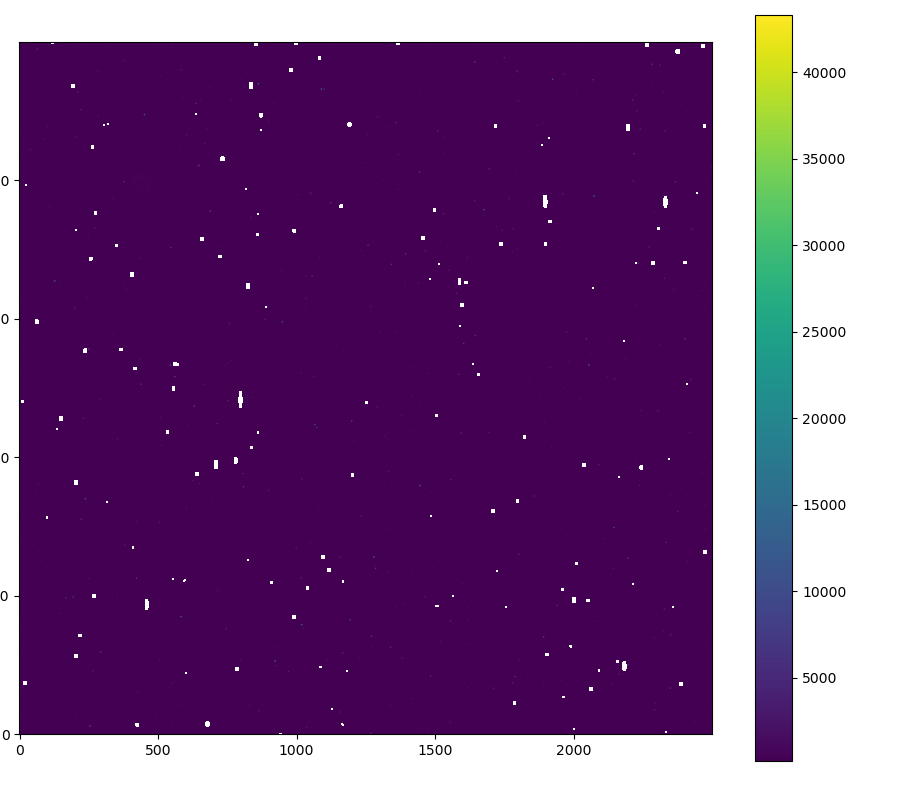

In [5]:
i_data = fits.getdata('./data/ztf_i_band.fits.gz')

fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(i_data, origin='lower')
fig.tight_layout()
fig.colorbar(cax)

The first thing that jumps out of this image is all the white pixels. They all have a value of `nan` because they have been flagged in the ZTF image processing pipeline as unreliable/no good. 

Note - from an aesthic standpoint, you can make these disappear by inputting the following: 

`np.where(np.isnan(i_data), np.nanmedian(i_data), i_data)`

to `imshow()`, which replaces the nan values with the median value from the image. While this is aesthetically more pleasing, it is also misleading as saturation is the main reason pixels will be masked.

We can quickly see the problem with a linear scaling. The dynamic range is too large to reveal any significant structure in the data. We can see the brightest stars, but that is it.

We can adjust the bounds on the plotted distribution to better highlight the salient features in the data.

**Problem 1b**

Make a histogram of the counts in the image. If necessary, adjust the default settings to get a better sense of the distribution. 

*Hint* - be sure to input a 1D array, `i_data` is 2D.

<IPython.core.display.Javascript object>


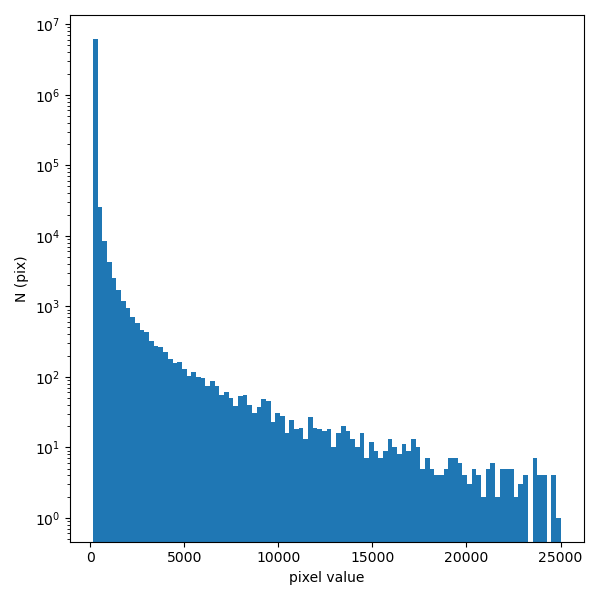

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(i_data.flatten(), 
        range=(150,25000), bins=100)
ax.set_yscale('log')
ax.set_xlabel('pixel value')
ax.set_ylabel('N (pix)')
fig.tight_layout()

We can see a nearly logarithmic distribution, with nearly all the pixels near the "noise floor" of 175 or so, and a large tail to larger values.

Based on this histogram, we will clip the range we show to create better constrast in the visualization.

**Problem 1c**

Replot the i-band image while limiting the range that is displayed to extend from $m$ the minimum pixel value to $M$ the maximum pixel value. While it is possible to do this directly in `imshow()`, use `numpy` to limit the range of what is plotted (the utility of this will become clear later).

<IPython.core.display.Javascript object>


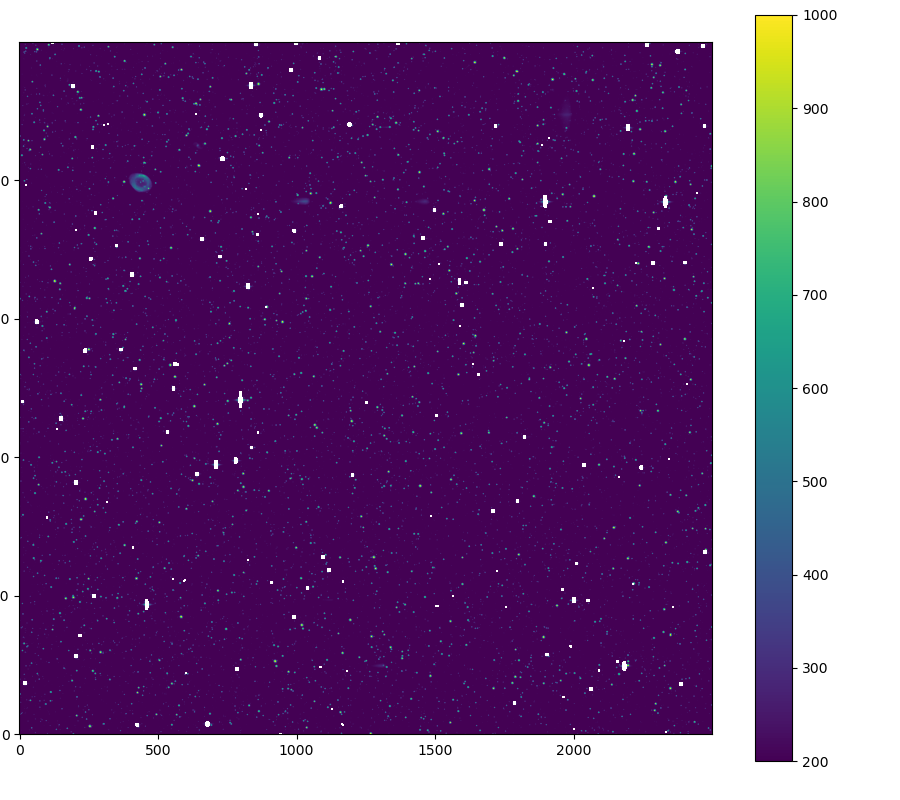

In [21]:
m = 200
M = 1000
i_display = np.clip(i_data, m, M)

fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(i_display, origin='lower')
fig.tight_layout()
fig.colorbar(cax)

Between these two examples we have seen the challenge of linear scales: (i) when featuring the full dynamic range they only feature "highlights" associated with the brightest pixels, (ii) when the the plotting range is limited then information about the brightest stars and galaxy cores is lost. 

**Problem 1d** 

Plot the i-band data using a log stretch. How does this compare to the linear stretch?

*Hint* – think about the salient features of the image. 

<IPython.core.display.Javascript object>


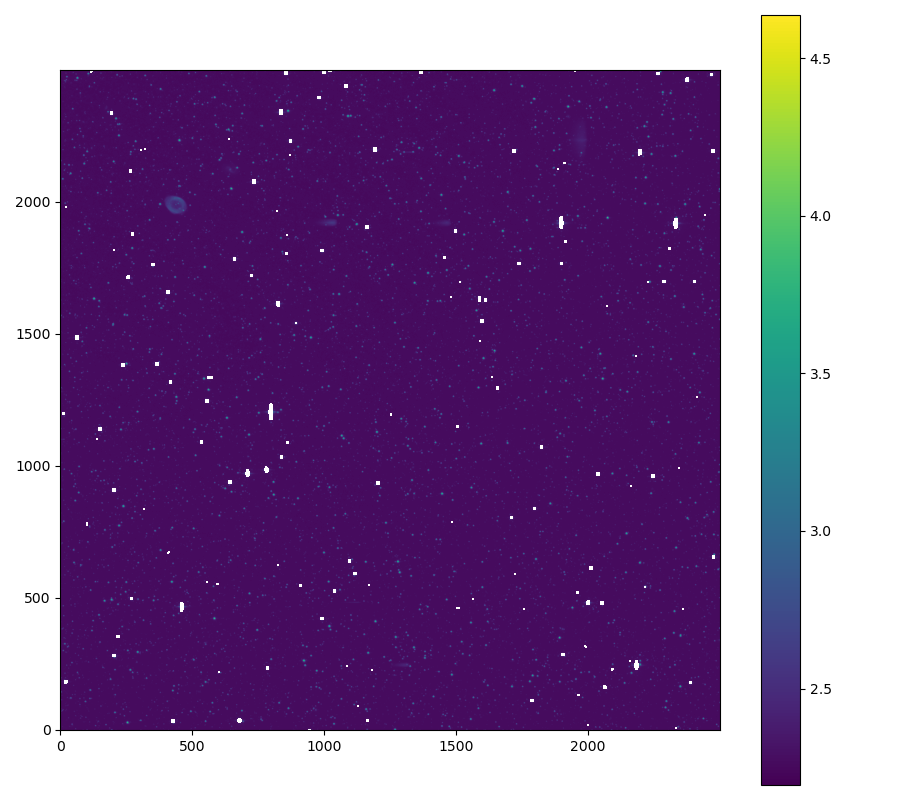

In [25]:
fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(np.log10(i_data), origin='lower')
fig.colorbar(cax)
fig.tight_layout()

Once again the brightest pixels dominate the range that is plotted, however, fainter structures are far more clear than with the linear stretch. 

It is also worth noting that the eye's response to intensity is roughly logarithmic\*. Therefore, plotting the data with a logrithmic stretch "mimics" what we actually see when looking up at the night sky.

\* This is the origin of the "magnitude" system, which is one of the worst units conventions in all of science. 

As before, we can do better by limiting the range that is displayed after the conversion to a log stretch. 

**Problem 1e**

Re-plot the i-band data with a log stretch and a cap on the minimum and maximum values to better highlight the "shadows" or faint structure within the data. 

<IPython.core.display.Javascript object>


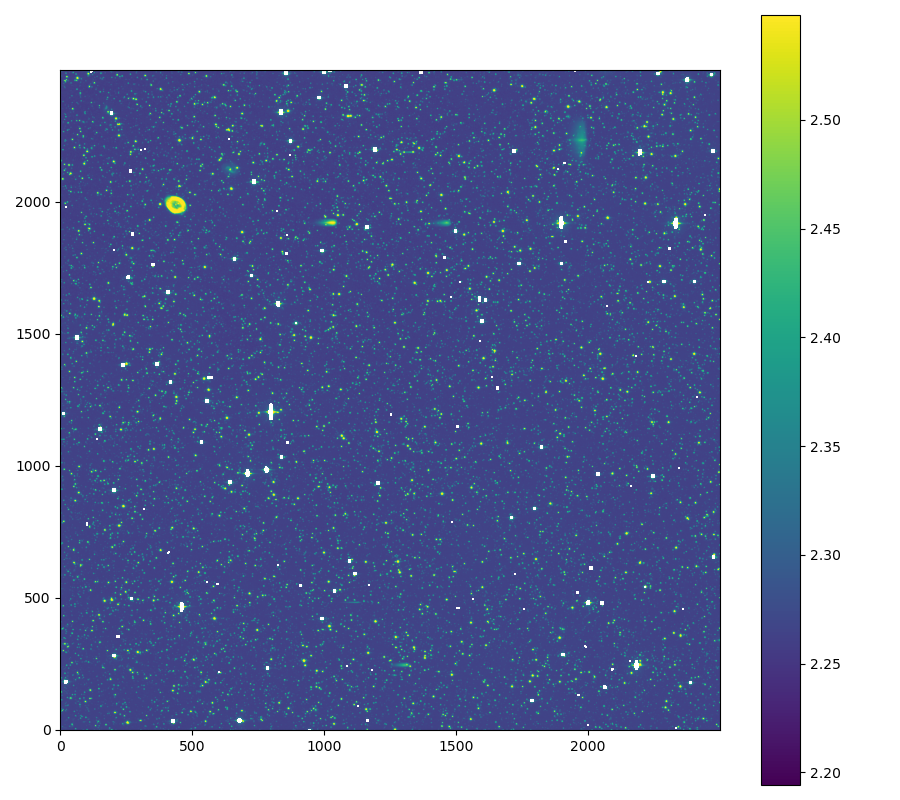

In [41]:
log_clipped = np.clip(np.log10(i_data), 
                      np.nanpercentile(np.log10(i_data),0),
                      np.nanpercentile(np.log10(i_data),99))
fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(log_clipped, origin='lower')
fig.colorbar(cax)
fig.tight_layout()

With the log scaling, we finally see the beautiful barred spiral galaxy to the northwest of the ring nebula. However, as was the case with the linear scaling, in order to see the spiral arms in the galaxy all the structure in the ring nebula gets blown out.

(There are also issues with log scaling when making false color images - we will come back to this.)

It is now generally accepted that the best scaling for CCD images is the [inverse hyperbolic sine](https://en.wikipedia.org/wiki/Inverse_hyperbolic_functions#Inverse_hyperbolic_sine). This non-linear transformation $$\operatorname{arsinh} x = \ln (x + \sqrt{x^2 + 1})$$ has the really nice property that for $|x| \ll 1$ $\operatorname{arsinh} x \approx x$ and for $|x| \gg 1$ $\operatorname{arsinh} x \approx \ln (2x)$. Therefore, with a single transformation we can get the best properties of each of the stretches condisered above. 

**Problem 1f**

Plot the i-band data with an inverse hyperbolic sine scaling.

<IPython.core.display.Javascript object>


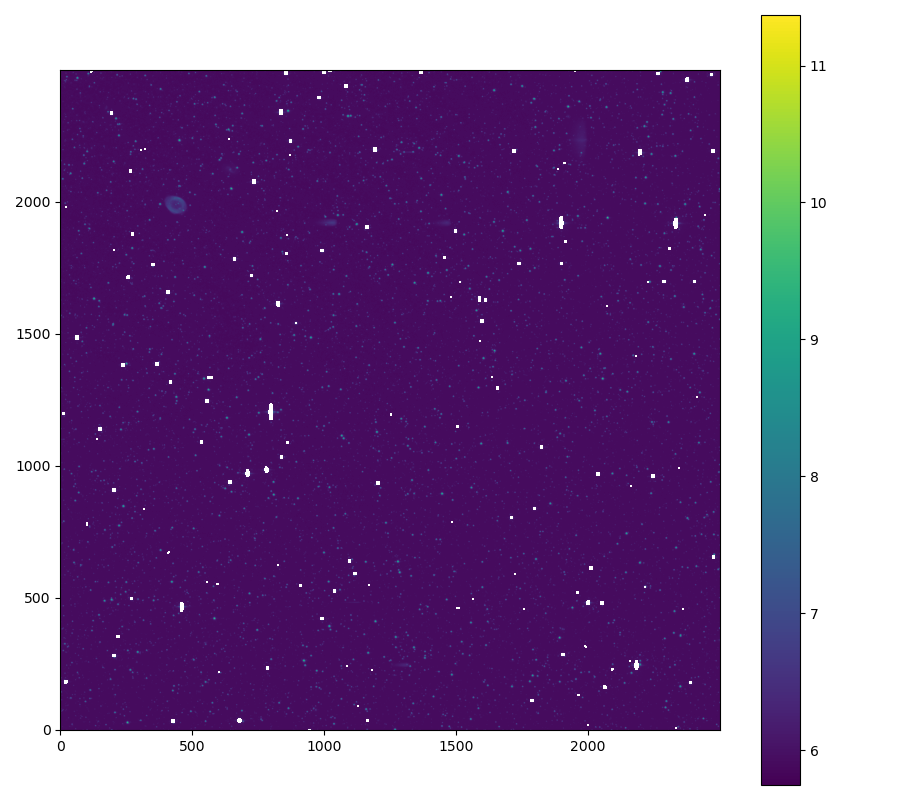

In [43]:
fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(np.arcsinh(i_data), origin='lower')
fig.colorbar(cax)
fig.tight_layout()

Off the shelf that looks pretty good. However we are missing some of the fainter structures. We can "re-center" the data so that the low-level shadows are closer to the $\sim$linear portion of the $\operatorname{arsinh}$ response curve.

**Problem 1g**

Subtract the median from the data and re-plot using an inverse hyperbolic sine scaling. 

*Hint* – do not forget about the `nan` values in the array.

<IPython.core.display.Javascript object>


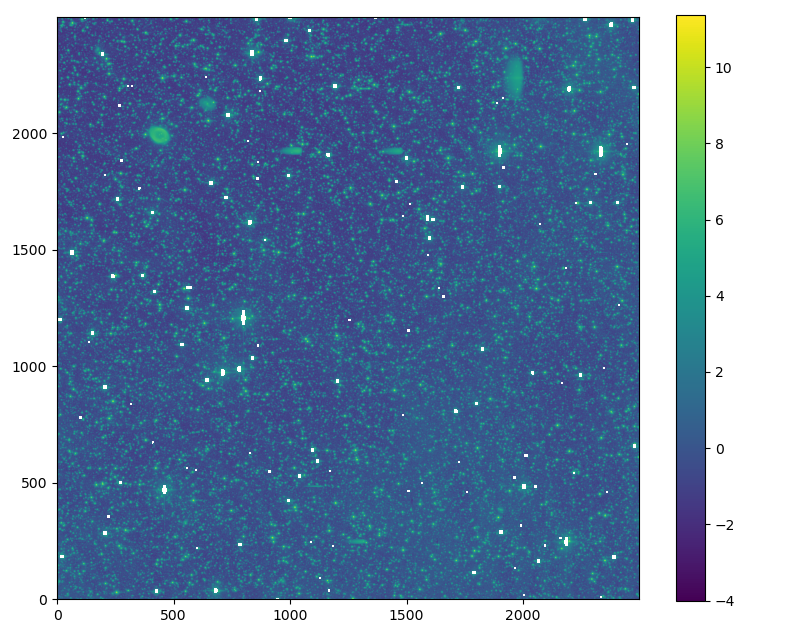

In [63]:
fig, ax = plt.subplots(figsize=(8,6.4))
cax = ax.imshow(np.arcsinh(i_data - np.nanmedian(i_data)), origin='lower')
# cax = ax.imshow(np.arcsinh(4*(i_data - np.nanmedian(i_data))/80)/4, origin='lower') # using softening parameter
fig.colorbar(cax)
fig.tight_layout()

And just like that we have the best looking image (by far!) with a relatively minimal amount of effort. In this representation the ring nebula is a little saturated/washed out. We can correct that with a softening parameter (more below). 

From **Problem 1** it is clear: the inverse hyperbolic sine is the best transform to use when displaying astronomical images. 